# 自动站模块的功能分析

385 ['2022-01-25 20:00:00', '2022-01-25 21:00:00', '2022-01-25 22:00:00', '2022-01-25 23:00:00', '2022-01-26 00:00:00', '2022-01-26 01:00:00', '2022-01-26 02:00:00', '2022-01-26 03:00:00', '2022-01-26 04:00:00', '2022-01-26 05:00:00', '2022-01-26 06:00:00', '2022-01-26 07:00:00', '2022-01-26 08:00:00', '2022-01-26 09:00:00', '2022-01-26 10:00:00', '2022-01-26 11:00:00', '2022-01-26 12:00:00', '2022-01-26 13:00:00', '2022-01-26 14:00:00', '2022-01-26 15:00:00', '2022-01-26 16:00:00', '2022-01-26 17:00:00', '2022-01-26 18:00:00', '2022-01-26 19:00:00', '2022-01-26 20:00:00', '2022-01-26 21:00:00', '2022-01-26 22:00:00', '2022-01-26 23:00:00', '2022-01-27 00:00:00', '2022-01-27 01:00:00', '2022-01-27 02:00:00', '2022-01-27 03:00:00', '2022-01-27 04:00:00', '2022-01-27 05:00:00', '2022-01-27 06:00:00', '2022-01-27 07:00:00', '2022-01-27 08:00:00', '2022-01-27 09:00:00', '2022-01-27 10:00:00', '2022-01-27 11:00:00', '2022-01-27 12:00:00', '2022-01-27 13:00:00', '2022-01-27 14:00:00', '2022-

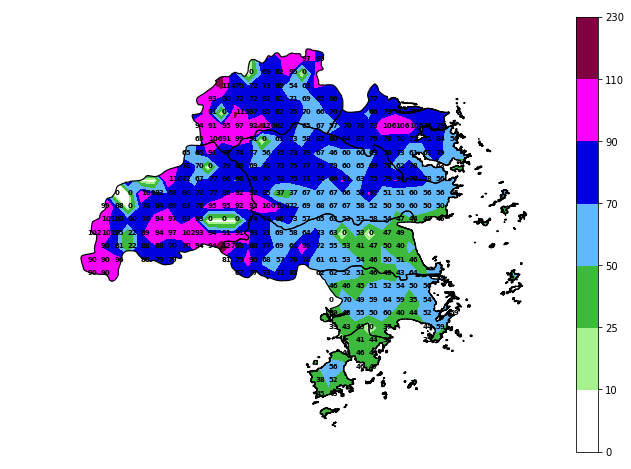

In [22]:
import base64
import json
import os
from io import BytesIO
from math import isnan

import geopandas as gpd
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
# import modin.pandas as pd
import pandas as pd
import shapefile
import xarray as xr
from affine import Affine
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from mpl_toolkits.basemap import Basemap
from ncmaps import Cmaps
from rasterio import features

import xesmf as xe
import redis
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
# import h5netcdf.legacyapi as netCDF4

os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'
import datetime as dtt
from datetime import *
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from func import *


class zdz_data:
    def __init__(self, start, end):
        self.start = start
        self.end = end
        # 基础数据
        self.station_data = None
        self.day_list = None
        self.rain_line = None
        self.rain_scatter = None
        self.station_all = self.read_csv()
        self.img = None
        self.event_data()
        self.rain_data()
        #self.img = self.plot_img()
    def plot_img(self,lat,lon,value):
        #线性插值
        N = len(value)
        a = []
        b = []
        z = []
        for i in range(N):
            if value[i]!=-9999.0:
                a.append(round(lon[i],2))
                b.append(round(lat[i],2))
                z.append(round(value[i],2))
        lat = np.array(b)
        lon = np.array(a)
        Zi = np.array(z)
        data_max = max(Zi)
        data_min = min(Zi)
        np.set_printoptions(precision = 2)
        x = np.arange(120.0,122.0,0.05)
        #print(x)
        y = np.arange(27.8,29.5,0.05)
        nx0 =len(x)
        ny0 =len(y)
        X, Y = np.meshgrid(x, y)#100*100
        P = np.array([X.flatten(), Y.flatten() ]).transpose()    
        Pi =  np.array([lon, lat ]).transpose()
        Z_linear = griddata(Pi, Zi, P, method = "nearest").reshape([ny0,nx0])
        #绘图
        colorslist = ['#FFFFFF','#A6F28f','#3DBA3D',"#61B8FF","#0000E1","#FA00FA","#800040"]# 降水
        cmaps = LinearSegmentedColormap.from_list('mylist',colorslist,N=7)
        levels = [0,10,25,50,70,90,110,230]
        # plt.rcParams.update({'font.size': 20})
        fig = plt.figure(figsize=[12,16]) 
    
        ax = fig.add_subplot(111)
        # plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace=0,wspace=0)
        filepath = "shpfile/"
        data_xr = xr.DataArray(Z_linear/10.0, coords=[ y,x], 
                        dims=["lat", "lon"])
        shp_da = add_shape_coord_from_data_array(data_xr, filepath+"taizhou.shp", "test")
        awash_da = shp_da.where(shp_da.test<7, other=np.nan)
        m = Basemap(llcrnrlon=120.0,llcrnrlat=27.8,urcrnrlon=122,urcrnrlat=29.5,resolution = None, projection = 'cyl')
        # 设置colorbar
        cbar_kwargs = {'shrink': 0.5}    
        cs = data_xr.plot.contourf(ax=ax, cmap=cmaps,levels =levels,cbar_kwargs=cbar_kwargs,add_labels=False)
        m.readshapefile(filepath+'taizhou','taizhou',color='k',linewidth=1.2)
        parallels = np.arange(27.8,29.5,0.2)
        # labels = [left,right,top,bottom]
        #m.drawparallels(parallels,labels=[True,False,True,False],color='dimgrey',dashes=[2, 3],fontsize= 12)  # ha= 'right'
        meridians = np.arange(120.0,122.0,0.2)
        #m.drawmeridians(meridians,labels=[False,True,False,True],color='dimgrey',dashes=[2, 3],fontsize= 12)
        plt.axis('off')
        len_lat = len(data_xr.lat.data)
        len_lon = len(data_xr.lon.data)
        for i in range(len_lon-1):
            for j in range(len_lat-1):
                y0 = round(27.8+j*0.05,2)
                x0 = round(120.0+i*0.05,2)
                if not isnan(awash_da.data[j,i]):
                    plt.text(x0,y0,str(int(awash_da.data[j,i])),fontsize= 7,fontweight = 800 ,color ="black")
        basemask(cs, ax, m, filepath+'taizhou')  
        # 保存为base64数据
        buffer = BytesIO()
        plt.savefig(buffer,bbox_inches='tight')  
        plot_img = buffer.getvalue()
        imb = base64.b64encode(plot_img) 
        ims = imb.decode()
        imd = "data:image/png;base64,"+ims
        return imd
    def sql_date(self):
        '''数据库读取sql数据'''
        print('读取数据库数据')
    def read_csv(self):
        '''
        1.数据读取---此方法为测试方法
        2.数据分段---每天
        3.每天统计
        '''
#         station_Mws = pd.read_csv("Mws_15.csv")
#         station_Aws = pd.read_csv("Aws_15.csv")
#         station_all = pd.concat([station_Aws, station_Mws])
        # station_all = pd.read_csv("data_zdz_height.csv")
        station_all = pd.read_csv("data_zdz_height.csv")
        return station_all
    def event_data(self):
        '''
        1.数据库查询
        2.数据分段---每天
        3.每天统计
        ['2022-04-14', 200,'高温 浓雾', '降水 大风', 200],
        '''
        dateList = []
        # 多少天
        dates = self.return_daylist()
        for i in dates:
            # 解析每天的数据
            # grouped_county = self.station_all.groupby('county')
            # grouped_IIiii = self.station_all.groupby('IIiii')
            # for i in self.grouped_county.size().index: 
            s_date = i + ' ' + '00:00'
            e_date = i + ' ' + '23:00'
            df_preday = self.station_all[(self.station_all['tTime'] >= s_date) & (self.station_all['tTime'] <= e_date)]
            #             df_RR= df_preday[df_preday['RR'] == -9999 ].count()
            #             grouped_county =
            date_preday = []
            # 日期
            day_date = str(i)
            # 面雨量
            rainfall = 200
            # 气温
            temp_min = df_preday[(df_preday['Height'] < 6000) & (df_preday['T'] > -400)]['T'].min()
            temp_min = temp_min / 10.0
            temp_max = df_preday[(df_preday['Height'] < 6000) & (df_preday['T'] > -400)]['T'].max()
            temp_max = temp_max / 10.0
            temp_label = ''
            if temp_min < 3.0:
                temp_label = '低温'
            elif temp_max > 35.0:
                temp_label = '高温'
            else:
                temp_label = ' '
            # 能见度
            # df_VV= df_preday[(df_preday['VV']>0.1)&(df_preday['VV']<500)]['VV'].count()
            vv = df_preday[(df_preday['VV'] > 0.1) & (df_preday['VV'] < 500)]['VV'].count()
            if vv > 0:
                view_label = '浓雾'
            else:
                view_label = ' '
                # 降水
            df_RR = df_preday[(df_preday['RR'] > 0.3) & (df_preday['RR'] < 8888)]['RR'].count()

            if df_RR > 0:
                pre_label = '降水'
            else:
                pre_label = ' '
            # 大风
            wind_count = df_preday[df_preday['fFy'] > 187]['fFy'].count()
            if wind_count > 0:
                wind_label = '大风'
            else:
                wind_label = ' '
            date_preday = [day_date, rainfall, temp_label + ' ' + view_label, pre_label + ' ' + wind_label, rainfall]
            dateList.append(date_preday)
        self.day_list = dateList
    #         print('event_data:返回一个每天的数组和日历所需的数据','气温',dateList)
    def return_daylist(self):
        '''
        返回每天的起始列表
        '''
        dates = []
        #         dt = datetime.datetime.strptime(self.start, "%Y-%m-%d")
        dt = dtt.datetime.strptime(self.start[0:10], "%Y-%m-%d")
        date = self.start[:10]
        while date <= self.end[:10]:
            dates.append(date)
            dt = dt + dtt.timedelta(1)
            date = dt.strftime("%Y-%m-%d")
        return dates
    def wind_data(self):
        '''
        1.根据sql语句计算8及以上大风的分布和排序
        '''
        data_wind_list = []
        station_all = self.station_all
        sort_data = {
            'IIiii': [],
            'county': [],
            'town': [],
            'value': []
        }
        # wind_max = station_all['fFy'].idxmax(axis=0)
        # station_max_name = station_all.iloc[wind_max,7]
        # station_max_data = self.station_data[station_max_name]
        grouped_IIiii = station_all.groupby('IIiii')
        for i in grouped_IIiii.size().index:
            data = grouped_IIiii.get_group(i)
            if data['fFy'].max() > 187:
                data_single = {}
                data_single['IIiii'] = data['IIiii'].iloc[0]
                data_single['county'] = data['county'].iloc[0]
                data_single['town'] = data['Town'].iloc[0]
                data_single['value'] = [data['lon'].iloc[0], data['lat'].iloc[0], data['fFy'].max() / 10.0]
                data_single['symbol'] = 'path://M10 10L50 10 50 20 20 20 20 40 50 40 50 50 20 50 20 100 10 100 10 10z'
                data_single['symbolRotate'] = data[data['fFy'] == data['fFy'].max()]['dFy'].iloc[0]
                sort_data['IIiii'].append(data['IIiii'].iloc[0])
                sort_data['county'].append(data['county'].iloc[0])
                sort_data['town'].append(data['Town'].iloc[0])
                sort_data['value'].append(data['fFy'].max() / 10.0)
                data_wind_list.append(data_single)
        # 对数据进行排序
        max_sort = max(sort_data['value'])
        level_sort = np.linspace(start=0.0, stop=max_sort, num=9)
        sort_data = pd.DataFrame(sort_data)
        sort_data['index'] = sort_data['value'].rank(ascending=0, method='dense')
        sort_out = sort_data.sort_values(by=['value'], ascending=[False])
        sort_html = ''
        # <tr><th>排序</th><th>乡镇</th><th>站点</th><th>能见度</th></tr>
        for i in sort_out['index']:
            table_html = '<tr><th>' + str(int(i)) + '</th><th>' + \
                         str(sort_out[sort_out['index'] == i]['town'].iloc[0]) + '</th><th>' + \
                         str(sort_out[sort_out['index'] == i]['IIiii'].iloc[0]) + '</th><th>' + \
                         str(sort_out[sort_out['index'] == i]['value'].iloc[0]) + '</th></tr>'
            sort_html = sort_html + table_html
        return data_wind_list, sort_html
    def view_data(self):
        '''
        1.根据sql语句计算低能见度的分布和排序
        '''
        '''
        1.根据sql语句计算8及以上大风的分布和排序
        '''
        data_view_list = []
        station_all = self.station_all
        sort_data = {
            'IIiii': [],
            'county': [],
            'town': [],
            'value': []
        }
        # wind_max = station_all['fFy'].idxmax(axis=0)
        # station_max_name = station_all.iloc[wind_max,7]
        # station_max_data = self.station_data[station_max_name]
        grouped_IIiii = station_all.groupby('IIiii')
        for i in grouped_IIiii.size().index:
            data = grouped_IIiii.get_group(i)
            if data['fFy'].max() > 187:
                data_single = {}
                data_single['IIiii'] = data['IIiii'].iloc[0]
                data_single['county'] = data['county'].iloc[0]
                data_single['town'] = data['Town'].iloc[0]
                data_single['value'] = [data['lon'].iloc[0], data['lat'].iloc[0], data['fFy'].max() / 10.0]
                data_single['symbol'] = 'path://M10 10L50 10 50 20 20 20 20 40 50 40 50 50 20 50 20 100 10 100 10 10z'
                data_single['symbolRotate'] = data[data['fFy'] == data['fFy'].max()]['dFy'].iloc[0]
                sort_data['IIiii'].append(data['IIiii'].iloc[0])
                sort_data['county'].append(data['county'].iloc[0])
                sort_data['town'].append(data['Town'].iloc[0])
                sort_data['value'].append(data['fFy'].max() / 10.0)
                data_view_list.append(data_single)
        # 对数据进行排序
        max_sort = max(sort_data['value'])
        level_sort = np.linspace(start=0.0, stop=max_sort, num=9)
        sort_data = pd.DataFrame(sort_data)
        sort_data['index'] = sort_data['value'].rank(ascending=0, method='dense')
        sort_out = sort_data.sort_values(by=['value'], ascending=[False])
        sort_html = ''
        # <tr><th>排序</th><th>乡镇</th><th>站点</th><th>能见度</th></tr>
        for i in sort_out['index']:
            table_html = '<tr><th>' + str(int(i)) + '</th><th>' + \
                         str(sort_out[sort_out['index'] == i]['town'].iloc[0]) + '</th><th>' + \
                         str(sort_out[sort_out['index'] == i]['IIiii'].iloc[0]) + '</th><th>' + \
                         str(sort_out[sort_out['index'] == i]['value'].iloc[0]) + '</th></tr>'
            sort_html = sort_html + table_html
        return data_view_list, sort_html
    def temp_data(self):
        '''
        1.根据sql语句计算高低温的分布和排序
        '''
#         temp_station_list = [
#             "58559","K8705","K8706","58652","58653","K8903","58568","K8818","58662","K8821",
#             "58660","K8609","K8282","58665","K8217","K8201","58661","58665","K8301","58663",
#             "58664","K8413","58666","58669","K8611","K8505","58667","58668"
#         ]
        temp_station_list = [
            "K8705","K8706","K8903","K8818","K8821",
            "K8609","K8282","K8217","K8201","K8301",
            "K8413","K8611","K8505"
        ]
        data_temp_max = []
        data_temp_min = []
        for i in temp_station_list:
            single_data_max = {}
            single_data_min = {}
            station_name = i
            single_data_max['name'] = i
            single_data_max['value'] = [self.station_data[i]['lon'].iloc[0], self.station_data[i]['lat'].iloc[0],
                                        self.station_data[i]['T'].max() / 10.0]
            single_data_min['name'] = i
            single_data_min['value'] = [self.station_data[i]['lon'].iloc[0], self.station_data[i]['lat'].iloc[0],
                                        self.station_data[i]['T'].min() / 10.0]
            data_temp_max.append(single_data_max)
            data_temp_min.append(single_data_min)
        return data_temp_max, data_temp_min
    def pre_day(self, date):
        '''
        日报的响应时间、触发后统计对应天的灾情
        '2022-04-14', 200,'高温 浓雾', '降水 大风', 
        '''
        # date = ['2022-04-14', 200,'低温 浓雾', '降水 大风', 200]
        # 计算时间
        today = dtt.datetime.strptime(date, '%Y-%m-%d')
        start_time = str(today + datetime.timedelta(days=-1))[0:10] + ' 20:00'
        end_time = str(today + datetime.timedelta(days=1))[0:10] + ' 08:00'
        data_all = self.station_all
        data_time = data_all[(data_all['tTime'] >= start_time) & (data_all['tTime'] <= end_time)]

        grouped_IIiii = data_time.groupby('IIiii')
        # 所需数据库
        pre_list = []
        wind_list = []
        view_list = []
        tmax_list = []
        tmin_list = []

        for i in grouped_IIiii.size().index:
            data = grouped_IIiii.get_group(i)
            # print(data)   
            # 低温 只操作指标站
            if data[data['T'] > -999]['T'].min() < 30:
                tmin_dir = {}
                tmin_dir['name'] = data['IIiii'].iloc[0]
                tmin_dir['value'] = [data['lon'].iloc[0], data['lat'].iloc[0], data['T'].tolist(), data['T'].min()]
                tmin_list.append(tmin_dir)
            # 高温   只操作指标站
            if data['T'].max() > 350:
                tmax_dir = {}
                tmax_dir['name'] = data['IIiii'].iloc[0]
                tmax_dir['value'] = [data['lon'].iloc[0], data['lat'].iloc[0], data['T'].tolist(), data['T'].max()]
                tmax_list.append(tmax_dir)
            # 大风
            if data[data['fFy'] > 187]['fFy'].max():
                wind_dir = {}
                wind_dir['name'] = data['IIiii'].iloc[0]
                wind_dir['value'] = [data['lon'].iloc[0], data['lat'].iloc[0], data['fFy'].tolist(), data['fFy'].max()]
                wind_dir['symbol'] = 'path://M10 10L50 10 50 20 20 20 20 40 50 40 50 50 20 50 20 100 10 100 10 10z'
                wind_dir['symbolRotate'] = data[data['fFy'] == data['fFy'].max()]['dFy'].iloc[0]
                wind_list.append(wind_dir)
            # 能见度   
            if data[(data['VV'] < 500) & (data['VV'] > 0)]['VV'].min():
                view_dir = {}
                view_dir['name'] = data['IIiii'].iloc[0]
                view_dir['value'] = [data['lon'].iloc[0], data['lat'].iloc[0], data['VV'].tolist(), data['VV'].min()]
                view_list.append(view_dir)
                # 降水  只操作指标站
            if data['RR'].max() > 0:
                pre_dir = {}
                data['RR'].replace(-9999, np.nan, inplace=True)
                pre_dir['name'] = data['IIiii'].iloc[0]
                pre_dir['value'] = [data['lon'].iloc[0], data['lat'].iloc[0], data['tTime'].tolist(),
                                    data['RR'].tolist(), data['RR'].sum()]
                pre_dir['symble'] = "circle"
                pre_list.append(pre_dir)
        return pre_list
    def text_data(self):
        '''用来处理风雨情统计数据'''
        start_time = start 
        end_time = end
        time_len =len(pd.date_range(start=start_time,end=end_time,freq='1H')) 
        station_all = self.station_all 
        # 计算面雨量
        grouped_county = station_all.groupby('county')        
        # 所需数据库
        pre_county = { }
        ## 
        iii_pre = {}
        iii_pre_data = {}
        iii_tmin_data = {}
        iii_tmax_data = {}
        iii_vvmin_data = {}
        iii_fmax_data = {}
        ##
        town_pre_data = {}
        # 面雨量   
        for i in grouped_county.size().index:
            data = grouped_county.get_group(i)
            data['RR'].replace(-9999, np.nan, inplace=True)
            ave = data['RR'].mean() * time_len /10.0
            pre_county[data['county'].iloc[0]] = ave
        #逐站统计    
        grouped_iii = station_all.groupby('IIiii') 
        for i in grouped_iii.size().index:
            data = grouped_iii.get_group(i)
            data['RR'].replace(-9999, np.nan, inplace=True)
            data['VV'].replace(-9999, np.nan, inplace=True)
            #data['fFy'].replace(-9999, np.nan, inplace=True)
            data['T'].replace(-9999, np.nan, inplace=True)
            # 存储变量
            iii_pre_data[data['IIiii'].iloc[0]] =  data['RR'].sum()/10.0 # 累计降水
            iii_tmin_data[data['IIiii'].iloc[0]] =  data['T'].min()      # 高温
            iii_tmax_data[data['IIiii'].iloc[0]] =  data['T'].max()      # 低温
            iii_vvmin_data[data['IIiii'].iloc[0]] =  data['VV'].min()    # 能见度
            iii_fmax_data[data['IIiii'].iloc[0]] =  np.nanmax(data['fFy'])# data['fFy'].max()    # 风力
        # 乡镇排序
        grouped_town = station_all.groupby('Town') 
        for i in grouped_town.size().index:
            data = grouped_town.get_group(i)
            data['RR'].replace(-9999, np.nan, inplace=True)
            town_pre_data[data['Town'].iloc[0]] =  data['RR'].sum()/10.0    
        # 文字排序的基本逻辑
        # 1. 降水
        # 2. 高低温
        # 3. 能见度
        # 4. 风
        # 5. 小时雨强
        ## 乡镇降水排序
        town_pre_sort = sorted(town_pre_data.items(), key=lambda x: x[1])

        ## 降水排序
        iii_pre_sort = sorted(iii_pre_data.items(), key=lambda x: x[1])

        ## 降水站点个数
        iii_pre_count = {
            '大于250毫米':len({k:v for k, v in iii_pre_data.items() if v>=51}.items()),
            '大于100毫米':len({k:v for k, v in iii_pre_data.items() if v>=100}.items()),
            '大于50毫米':len({k:v for k, v in iii_pre_data.items() if v>=50}.items()),
            '大于25毫米':len({k:v for k, v in iii_pre_data.items() if v>=25}.items()),
            '大于10毫米':len({k:v for k, v in iii_pre_data.items() if v>=10}.items()),
            '大于5毫米':len({k:v for k, v in iii_pre_data.items() if v>=5}.items()),
            '大于1毫米':len({k:v for k, v in iii_pre_data.items() if v>=0.1}.items())
        } 
        ## 风力
        iii_wind_sort = sorted(iii_fmax_data.items(), key=lambda x: x[1], reverse=True)
        iii_wind_count = {
            'wind_rank':[16,15,14,13,12,11,10,9,8],
            'wind_list':[
                len({k:v for k, v in iii_fmax_data.items() if v>=51 and v<56}.items()),
                len({k:v for k, v in iii_fmax_data.items() if v>=47 and v<51}.items()),
                len({k:v for k, v in iii_fmax_data.items() if v>=42 and v<47}.items()),
                len({k:v for k, v in iii_fmax_data.items() if v>=37 and v<42}.items()),
                len({k:v for k, v in iii_fmax_data.items() if v>=32 and v<37}.items()),
                len({k:v for k, v in iii_fmax_data.items() if v>=27 and v<32}.items()),
                len({k:v for k, v in iii_fmax_data.items() if v>=22 and v<27}.items()),
                len({k:v for k, v in iii_fmax_data.items() if v>=17 and v<22}.items()),
                len({k:v for k, v in iii_fmax_data.items() if v>=12 and v<17}.items())      
            ] 
        } 
        ## 能见度
        iii_vv_sort = sorted(iii_vvmin_data.items(), key=lambda x: x[1])
        iii_vv_count = {
            'vv_rank':["小于50米的强浓雾","小于200米浓雾","小于500米的浓雾"],
            'vv_list':[
                len({k:v for k, v in iii_vvmin_data.items() if v>=0 and v<50}.items()),
                len({k:v for k, v in iii_vvmin_data.items() if v>=50 and v<200}.items()),
                len({k:v for k, v in iii_vvmin_data.items() if v>=200 and v<500}.items()),
    
            ] 
        } 
        ## 低温
        iii_tmin_sort = sorted(iii_tmin_data.items(), key=lambda x: x[1])
        iii_tmin_count = {
            'tmin_rank':["小于-3度","小于0度","小于3度"],
            'tmin_list':[
                len({k:v for k, v in iii_tmin_data.items() if v>=0 and v<3}.items()),
                len({k:v for k, v in iii_tmin_data.items() if v>=-3 and v<0}.items()),
                len({k:v for k, v in iii_tmin_data.items() if v>=-20 and v<-3}.items()),
    
            ] 
        } 
        ## 高温
        iii_tmax_sort = sorted(iii_tmax_data.items(), key=lambda x: x[1])
        iii_tmax_count = {
            'tmax_rank':["大于35度","小于38度","小于40度"],
            'tmax_list':[
                len({k:v for k, v in iii_tmax_data.items() if v>=0 and v<3}.items()),
                len({k:v for k, v in iii_tmax_data.items() if v>=-3 and v<0}.items()),
                len({k:v for k, v in iii_tmax_data.items() if v>=-20 and v<-3}.items()),
    
            ] 
        } 
        
        
        # 输出文档内容
        ## 时间开头
        text_all = "风雨情通报:"
        time_text = self.start + "到" + self.end
        ## 面雨量
        county_text = "各县市面雨量分别为:"
        for single in sorted(pre_county.items(), key=lambda x: x[1], reverse=True):
            single_text = single[0]+ "" + str(round(single[1],2)) + "毫米;"
            county_text = county_text + single_text  
        ## 雨量前五
        iii_pre_text = "单站前五：" + iii_pre_sort[-1][0] + "：" + str(iii_pre_sort[-1][1]) + "毫米,"\
            + iii_pre_sort[-2][0]+ "：" + str(iii_pre_sort[-2][1]) + "毫米,"\
            + iii_pre_sort[-3][0]+ "：" + str(iii_pre_sort[-3][1]) + "毫米,"\
            + iii_pre_sort[-4][0]+ "：" + str(iii_pre_sort[-4][1]) + "毫米,"\
            + iii_pre_sort[-5][0]+ "：" + str(iii_pre_sort[-5][1]) + "毫米."
        ## 乡镇降水前五
        town_pre_text = "乡镇前五：" + town_pre_sort[-1][0] + "：" + str(town_pre_sort[-1][1]) + "毫米,"\
            + town_pre_sort[-2][0]+ "：" + str(town_pre_sort[-2][1]) + "毫米,"\
            + town_pre_sort[-3][0]+ "：" + str(town_pre_sort[-3][1]) + "毫米,"\
            + town_pre_sort[-4][0]+ "：" + str(town_pre_sort[-4][1]) + "毫米,"\
            + town_pre_sort[-5][0]+ "：" + str(town_pre_sort[-5][1]) + "毫米."        
        ## 雨强前三
        ri_pre_text = ""
        ## 降水站点个数
        count_pre_text = "其中:"
        for key, value in iii_pre_count.items():
            if value!=0:
                count_pre_text = count_pre_text + key + "有" + str(value) + "站,"
        ## 大风
        wind_text = "沿海出现"
        wind_max = "16级"
        wind_min = "15"
        for i in range(len(iii_wind_count['wind_list'])):
            if iii_wind_count['wind_list'][i]>0:
                wind_max = str(iii_wind_count['wind_rank'][i]) + "级"
                break
        wind_reve = iii_wind_count['wind_list'][::-1]
        for i in wind_reve:
            if i>0:
                index = wind_reve.index(i)
                wind_min = str(iii_wind_count['wind_rank'][9-index])
                break  
        wind_text = wind_text + wind_min + "~" + wind_max + "大风." 
        wind_text = wind_text + "风力较大的有：" + iii_wind_sort[0][0] + "：" + str(iii_wind_sort[0][1]/10.0) + "米/秒,"\
            + iii_wind_sort[1][0]+ "：" + str(iii_wind_sort[1][1]/10.0) + "米/秒,"\
            + iii_wind_sort[2][0]+ "：" + str(iii_wind_sort[2][1]/10.0) + "米/秒,"\
            + iii_wind_sort[3][0]+ "：" + str(iii_wind_sort[3][1]/10.0) + "米/秒,"\
            + iii_wind_sort[4][0]+ "：" + str(iii_wind_sort[4][1]/10.0) + "米/秒."    
        ## 能见度
        vv_text = ""
        if iii_vv_count['vv_list'][0]>0:
            vv_text = vv_text + "沿海出现小于50米的强浓雾。"
        elif iii_vv_count['vv_list'][1]>0:
            vv_text = vv_text + "沿海出现小于200米的强浓雾。"
        else:
            vv_text = vv_text + "沿海出现小于500米的浓雾。"
        ## 温度
        temp_text = "主城区最高温度："
        temp_text = temp_text + str(iii_tmax_data['K8505']) + "度。" + "主城区最低温度：" + str(iii_tmin_data['K8505']) + "度。"
        temp_text = temp_text + "其中全市" 
        for i in range(len(iii_tmin_count['tmin_list'])):
            if iii_tmin_count['tmin_list'][i]:
                temp_text = temp_text + iii_tmin_count['tmin_rank'][i] + "的有" + str(iii_tmin_count['tmin_list'][i]) + "站。"
        for i in range(len(iii_tmax_count['tmax_list'])):
            if iii_tmax_count['tmax_list'][i]:
                temp_text = temp_text + iii_tmax_count['tmax_rank'][i] + "的有" + str(iii_tmax_count['tmax_list'][i]) + "站。"      
        text_all = text_all + time_text+county_text+iii_pre_text+town_pre_text+count_pre_text+wind_text+vv_text+temp_text
        #print(text_all)
#         print("风雨情通报:",time_text,county_text,iii_pre_text,town_pre_text,count_pre_text,wind_text+vv_text,temp_text)
        #print(sorted(iii_fmax_data.items(), key=lambda x: x[1], reverse=True)) 
    def rain_data(self):
        '''
        1.根据起始时间计算面雨量的sql语句
        2.根据初始语句返回每站的总降水量
        '''
        station_all = self.station_all

        data_rain = {
            'rain_sum': {
                'time': [],
                'data': []
            },
            'IIiii_data': {}

        }
        station_list = ['K8734','K8748']
        time_index = []
        station_k8734 = []
        station_k8748 = []
        grouped_tTime = station_all.groupby('tTime')
        for i in grouped_tTime.size().index:
            data = grouped_tTime.get_group(i)
            data['RR'].replace(-9999, np.nan, inplace=True)
            rain_mean = data['RR'].mean() / 10.0
            rain_time = i
            data_rain['rain_sum']['time'].append(rain_time)
            time_index.append(rain_time)
            # 每个乡镇的降水情况
            station_k8748.append(data[data['IIiii']=='K8748']['RR'].values[0] if len(data[data['IIiii']=='K8748']['RR'].values)==1 else 0.0)
            station_k8734.append(data[data['IIiii']=='K8734']['RR'].values[0] if len(data[data['IIiii']=='K8734']['RR'].values)==1 else 0.0)

            data_rain['rain_sum']['data'].append(rain_mean)
        print(len(station_k8734),time_index)
        # 导出单站数据
        grouped_IIiii = station_all.groupby('IIiii')
        rain_scatter = []
        #         {
        #          name: "K8515", value: [121.2, 28.6, 110],
        #          symbol: 'circle'
        #         }
        lat = []
        lon = []
        value = []
        pre_county_list = {}
        for i in grouped_IIiii.size().index:
            data = grouped_IIiii.get_group(i)
            data['RR'].replace(-9999, np.nan, inplace=True)
            #print(data)
            if data['IIiii'].iloc[0] in station_list:
                data_rr = data.sort_values('tTime') 
                StationName = data_rr['StationName'].iloc[0]
                pre_county_list[StationName] = data_rr['RR'] 
            station_name = str(i)
            data_rain['IIiii_data'][station_name] = data
            single_data = {}
            single_data['name'] = station_name
            single_data['value'] = [data['lon'].iloc[0], data['lat'].iloc[0], data['RR'].sum() / 10.0]
            lat.append(data['lat'].iloc[0])
            lon.append(data['lon'].iloc[0])
            value.append(data['RR'].sum())
            single_data['symble'] = 'circle'
            rain_scatter.append(single_data)  
        self.station_data = data_rain['IIiii_data']
        self.rain_line = [data_rain['rain_sum']['time'], data_rain['rain_sum']['data']]
        self.rain_scatter = rain_scatter
        self.img = self.plot_img(lat,lon,value)
        
        

start = '2022-01-25 20:00'
end = '2022-02-10 06:00'

zdz_worker = zdz_data(start, end)
zdz_worker.text_data()
# context = {
#     'status': "ok",
#     'day_list': zdz_worker.day_list,
#     'day_range': [zdz_worker.day_list[0][0], zdz_worker.day_list[-1][0]],
#     'rain_line': zdz_worker.rain_line,
#     'rain_scatter': json.dumps(zdz_worker.rain_scatter),
#     'rain_img':zdz_worker.img
#     }

In [17]:
a = x if 2>3 1 0

SyntaxError: invalid syntax (1540831912.py, line 1)